# __Python for finance - L3 EIF__

## __European Options Pricer on Python__

First you need to import the different packages that will be used.

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from scipy.stats import norm
from typing import List, Dict

## The theory

#### The Black-Scholes Model

The Black–Scholes model assumes that the market consists of at least one risky asset, usually called the stock, and one riskless asset, usually called the money market, cash, or bond.

Assumptions on the market:

* The rate of return on the riskless asset is constant and thus called the risk-free interest rate
* The instantaneous log returns of the stock price is an infinitesimal random walk with drift and volatility (geometric Brownian motion) and assumes this drift and volatility are constant
* The stock does not pay a dividend

Assumptions on the underlying security:

* There is no arbitrage opportunity (i.e. there is no way to make a riskless profit)
* It is possible to borrow and lend any amount, even fractional, of cash at the riskless rate
* It is possible to buy and sell any amount, even fractional, of the stock (this includes short selling)
* The above transactions do not incur any fees or costs (i.e. frictionless market).

#### Equations

> $$\frac{\partial V}{\partial t} + \frac{1}{2}\sigma^{2}S^{2}\frac{\partial^{2} V}{\partial S^{2}}+rS\frac{\partial V}{\partial S}-rV=0$$

The key financial insight behind the equation is that one can perfectly hedge the option by buying and selling the underlying asset in just the right way and consequently create an arbitrage free environment. This hedge, in turn, implies that there is only one right price for the option, as returned by the Black–Scholes formula. For this dynamic hedging to work, one must continuously hedge the movement in the underlying stock with the option which in reality, is prohibitive due to transaction costs.

For a Call Option :

> $$C(S, t) = N(d_{1})S - N(d_{2})Ke^{-r(T-t)}$$

For a Put Option :

> $$P(S, t) = N(-d_{2})Ke^{-r(T-t)} - N(-d_{1})S$$

where

> $$d_{1} = \frac{ln(\frac{S}{K})+(r+\frac{\sigma^{2}}{2})(T-t)}{\sigma\sqrt{T-t}}$$

and

> $$d_{2} = d_{1} - \sigma\sqrt{T-t}$$

where

* $N(\cdot)$ is the cumulative distribution function of the standard normal distribution
* $T - t$ is the time to expiration
* $S$ is the spot price of the underlying asset
* $K$ is the strike price
* $r$ is the risk free rate (annual rate, expressed in terms of continuous compounding)
* $\sigma$ is the volatility of returns of the underlying asset

Source: https://en.wikipedia.org/wiki/Black–Scholes_model

## Implementation of the thoery

In [2]:
class Asset(object):
    """
    This class is used to represent an asset object on wich we base an european option of type EuropeanOption. 
    An instance of this class is called as a parameter for the initialisaton of the EuropeanOption class.
    """

    def __init__(self, volatility: float, price: float):
        self._volatility = volatility
        self._price = price

    @property
    def volatility(self) -> float:
        return self._volatility

    @property
    def price(self) -> float:
        return self._price


class EuropeanOption(object):
    """
    This class is used to represent a European Option. 
    It contains the common characteristics of both Call and Put options as properties.
    
    :property strike_price: the value of the option's strike 
    :property time_to_expiration: time in years from option's expiration date
    :property underlying: Object of type Asset representing the underlying asset on wich the option is based
    :property rf_rate: risk free rate considered for the pricing
    :property price: calculated price of the option with the Black-Scholes model
    """

    def __init__(
        self,
        strike_price: float,
        time_to_expiration: float,
        underlying: Asset,
        rf_rate: float,
    ):
        self._strike_price = strike_price  # Strike price of the Option
        self._time_to_expiration = time_to_expiration  # Maturity of the Option
        self._underlying = underlying
        self._rf_rate = rf_rate

    @property
    def strike_price(self) -> float:
        return self._strike_price

    @property
    def time_to_expiration(self) -> float:
        return self._time_to_expiration

    @property
    def underlying(self) -> Asset:
        return self._underlying

    @property
    def rf_rate(self) -> float:
        return self._rf_rate

    @property
    def price(self) -> float:
        return self._price

    @price.setter
    def price(self, price):
        self._price = price

    def d1(self) -> float:
        """ 
        This function compute the value of the parameter d1 of the Black-Scholes model.
        It takes no parameter as the calculations are based on the propeties of the class itself.
        
        :return: the value of d1
        """

        return ((1.0 / (self.underlying.volatility * np.sqrt(self.time_to_expiration)))
                * (np.log(self.underlying.price / self.strike_price)
                   + self.time_to_expiration
                   * (self.rf_rate + (self.underlying.volatility ** 2.0) / 2)
                  )
               )

    def d2(self) -> float:
        """ 
        This function compute the value of the parameter d2 of the Black-Scholes model.
        It takes no parameter as the calculations are based on the propeties of the class itself.
        
        :return: the value of d2
        """

        return self.d1() - self.underlying.volatility * np.sqrt(self.time_to_expiration)

    
    def __N(self, x):
        """
        Normal cumulative density function which returns the cumulative density under the normal curve 
        along the point 'x' where the cumulative density is calculated.

        Refer to scipy.stats documentation for more information.
        """
        return norm.cdf(x)

    def compute_price(self, sign: float):
        """
        This function compute the price property of the class from the other properties 
        in accordance with the Black-Scholes model.

        :param sign: since the the Call and Put value formulas differ only by a sign, 
                     this parameter aims at unifying the formulas in one function
        :return: the option object itself
        """

        valid_signs = {1.0, -1.0}
        if sign not in valid_signs:
            raise ValueError(f"The :sign:float parameter must be in {valid_signs}")
        else:
            d1 = self.d1()
            d2 = self.d2()
            self.price = sign * (self.__N(sign * d1) * self.underlying.price
                                 - self.__N(sign * d2)
                                 * self.strike_price
                                 * np.exp(-self.rf_rate * self.time_to_expiration)
                                )

        return self

In [3]:
class Call(EuropeanOption):
    """
    Child class of the EuropeanOption class. It inherits all the basics properties of the mother class
    and override the compute_price() function to only compute the price of the Put.
    """

    def compute_price(self) -> float:
        """
        This function ovverride the mother class function.
        
        :return: the option object itself
        """

        return super().compute_price(1.0)


class Put(EuropeanOption):
    """ 
    Child class of the EuropeanOption class. It inherits all the basics properties of the mother class
    and override the compute_price() function to only compute the price of the Call.
    """

    def compute_price(self) -> float:
        """
        This function ovverride the mother class function.
        
        :return: the option object itself
        """

        return super().compute_price(-1.0)

In [4]:
class EOMaths(object):
    """
    This class is used to regroup multiple function in the same place. 
    The functions could be defined independantly but this class better structures the code 
    therefore improving readability.
    """

    @staticmethod
    def compute_price_of_list(EO_list: List[EuropeanOption]) -> List[EuropeanOption]:
        """
        This function compute the prices of a given list of EuropeanOption objects.

        :return: a list of EuropeanOption with their price property computed.
        """

        return list(map(lambda EO: EO.compute_price(), EO_list))

    @staticmethod
    def EOs_for_underlying_prices_in(inf: float, sup: float, step: float, option: EuropeanOption
                                    ) -> Dict[str, List[EuropeanOption]]:
        """ 
        This function computes the prices of the Call and Put options 
        derived from a given EuropeanOption object 
        for a defined range of underlying asset prices.

        :param inf: minimum value for the price range
        :param sup: maximum value for the price range
        :param step: step value for the price range
        :param option: EuropeanOption object with all given values except the price of the underlying asset
        :return: Dict object containing two list of Call and Put options with their prices computed
        """

        prices = np.arange(inf, sup, step)

        EO_dict = {
            "Call": [
                Call(
                    option.strike_price,
                    option.time_to_expiration,
                    Asset(option.underlying.volatility, price),
                    option.rf_rate,
                )
                for price in prices
            ],
            "Put": [
                Put(
                    option.strike_price,
                    option.time_to_expiration,
                    Asset(option.underlying.volatility, price),
                    option.rf_rate,
                )
                for price in prices
            ],
        }

        EO_dict["Call"] = EOMaths.compute_price_of_list(EO_dict["Call"])
        EO_dict["Put"] = EOMaths.compute_price_of_list(EO_dict["Put"])

        return EO_dict

    @staticmethod
    def EOs_for_volatilities_in(inf: float, sup: float, step: float, option: EuropeanOption
                               ) -> Dict[str, List[EuropeanOption]]:
        """ 
        This function computes the prices of the Call and Put options 
        derived from a given EuropeanOption object 
        for a defined range of volatilities.

        :param inf: minimum value for the volatility range
        :param sup: maximum value for the volatility range
        :param step: step value for the volatility range
        :param option: EuropeanOption object with all given values except the volatility of the underlying
        :return: Dict object containing two list of Call and Put options with their prices computed
        """

        volatilities = np.arange(inf, sup, step)

        EO_dict = {
            "Call": [
                Call(
                    option.strike_price,
                    option.time_to_expiration,
                    Asset(volatility, option.underlying.price),
                    option.rf_rate,
                )
                for volatility in volatilities
            ],
            "Put": [
                Put(
                    option.strike_price,
                    option.time_to_expiration,
                    Asset(volatility, option.underlying.price),
                    option.rf_rate,
                )
                for volatility in volatilities
            ],
        }

        EO_dict["Call"] = EOMaths.compute_price_of_list(EO_dict["Call"])
        EO_dict["Put"] = EOMaths.compute_price_of_list(EO_dict["Put"])

        return EO_dict

In [5]:
def plot_prices_ulprice(EO_list: List[EuropeanOption], ax: mpl.axes.Axes, title: str):
    """ 
    This function display the plot of the prices of an option according to the underlying asset price.
    It is given a list of EuropeanOption with all of their properties set to the same values
    except the underlying asset price.
    
    :param EO_list: list of EuropeanOption objects
    :param ax: an matplotlib.axes.Axes object displayed on a figure
    :param title: the title of the plot

    WARNING: the elements of the EO_list must have their price property computed
    """

    ax.plot([EO.underlying.price for EO in EO_list],
            [EO.price for EO in EO_list],
            label=f"strike = {EO_list[0].strike_price}",
           )
    ax.set_title(label=title, fontsize="xx-large", pad=15)
    ax.legend(fontsize="xx-large")


def plot_price_ulvolatility(EO_list: List[EuropeanOption], ax: mpl.axes.Axes, title: str):
    """ 
    This function display the plot of the prices of an option according to the underlying asset volatility.
    It is given a list of EuropeanOption with all of their properties set to the same values
    except the underlying asset volatility.
    
    :param EO_list: list of EuropeanOption objects
    :param ax: an matplotlib.axes.Axes object displayed on a figure
    :param title: the title of the plot

    WARNING: the elements of the EO_list must have their price property computed
    """

    ax.plot(
        [EO.underlying.volatility for EO in EO_list],
        [EO.price for EO in EO_list],
        label=f"strike = {EO_list[0].strike_price}",
    )
    ax.set_title(label=title, fontsize="xx-large", pad=15)
    ax.legend(fontsize="xx-large")

def save_individual_plot(ax_line: int, ax_column: int):
    """
    As we are presenting every plot in a single matplotlib.pyplot.figure object, 
    we cannot individually save the plots with the predefined module function.
    This function cut apart the matplotlib.pyplot.figure object and saves the a given Axes in a PNG file.
    
    WARNING: this function can only be called if a figure object as already been created. 
    
    :param ax_line: the line index of the axes to save (begin at 0)
    :param ax_column: the column index of the axes to save (begin at 0)
    """
    
    # Compute the index value in the list of axes, from the coordinates on the figure:
    ax_index = 2 * ax_line + ax_column
    # Create a valid file name from the title of the axes:
    file_name = fig.axes[ax_index].title.get_text().replace(" ", "_").lower()

    # Compute the size of the part of the matplotlib.pyplot.figure object to save
    extent = (fig.axes[ax_index].get_window_extent().transformed(fig.dpi_scale_trans.inverted()))
    # Saving the plot as PNG file
    fig.savefig(file_name + ".png", bbox_inches=extent.expanded(1.2, 1.2))

## Application of the theory

The next section uses all the Classes and Functions defined above in order to plot Call and Put values according to the price and volatility of the underlying asset. For each situation the plots are displayed for multiple values of the option's strike prices. It then saves the plot as PNG files.

The parameters are set with constant variables at the beginning of the cell.

A standard European Option on wich the calculations are based is defined with the following parameters:

* The time to expiration is equal to the maturity as the computations are made at the creation of the option, the value is 6 months $$T - t = M = \frac{6}{12}$$
* The risk free rate is $$r = 0.02$$
* The price of the underlying asset is $$S = 90$$
* The volatility of the underlying asset is $$\sigma = 0.25$$
* The strike prices are in the following list of integer $$[80, 85, 90, 95, 100]$$


In [6]:
# Constant value assignments
OPTION_MATURITY = 6.0 / 12.0
RISK_FREE_RATE = 0.02
STANDARD_ASSET = Asset(volatility=0.25, price=90)
STRIKES = np.arange(80, 101, 5)
STANDARD_EOs = list(
    map(
        lambda strike: EuropeanOption(
            strike_price=strike,
            time_to_expiration=OPTION_MATURITY,
            underlying=STANDARD_ASSET,
            rf_rate=RISK_FREE_RATE,
        ),
        STRIKES,
    )
)

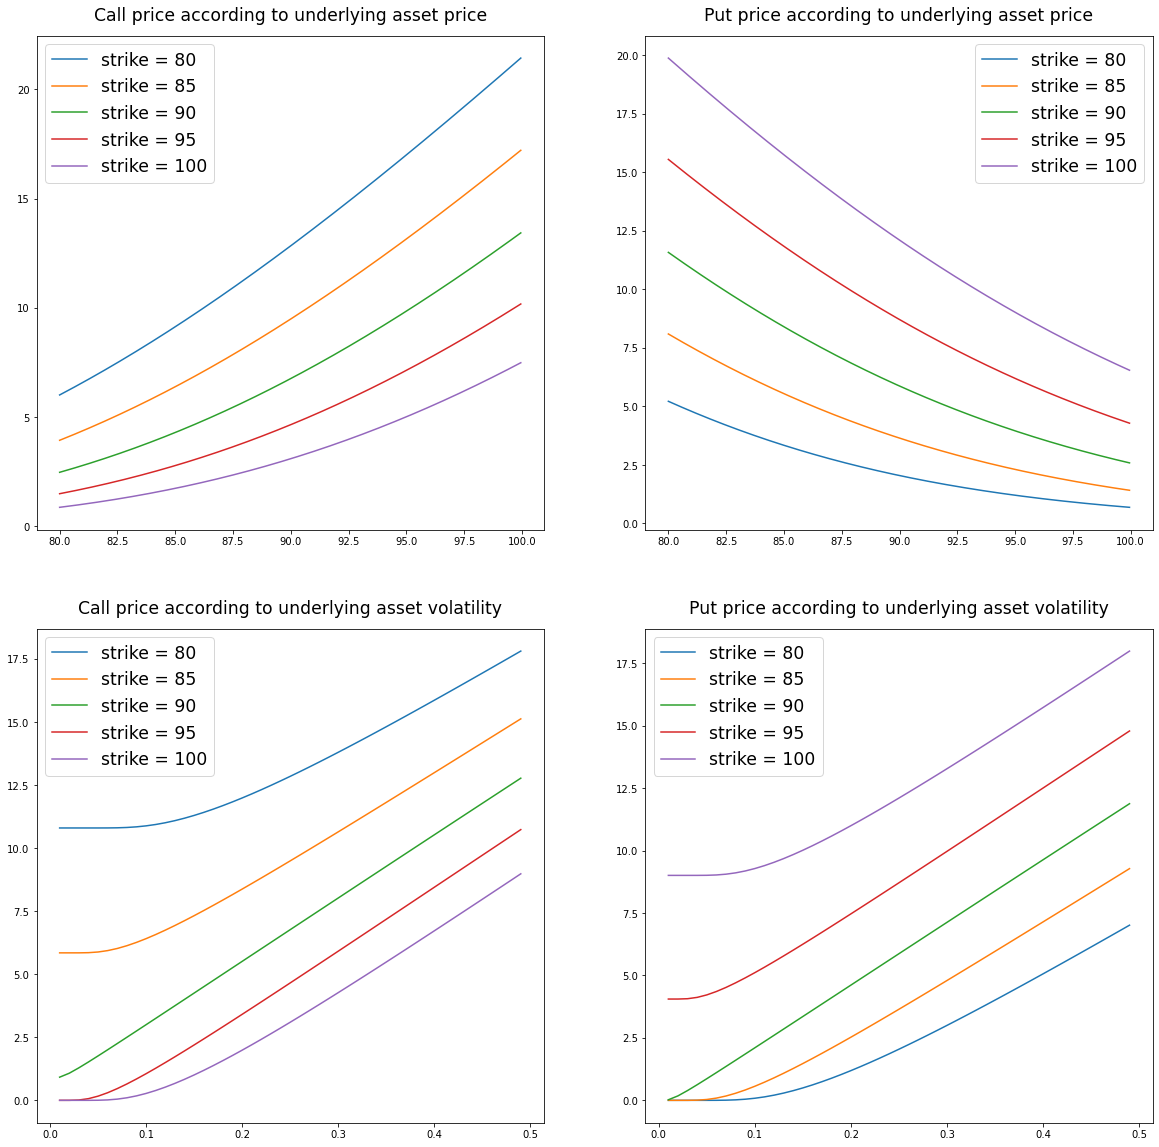

In [7]:
# Create a matplotlib.pyplot.figure object with a grid of four matplotlib.axes.Axes object
fig, axs = plt.subplots(2, 2, figsize=[20, 20])

# Compute, display and save the plots of the option's price according to the underlying asset price
for EO in STANDARD_EOs:

    EO_dict = EOMaths.EOs_for_underlying_prices_in(
        inf=80, sup=100, step=0.05, option=EO
    )

    plot_prices_ulprice(
        EO_dict["Call"], axs[0, 0], "Call price according to underlying asset price"
    )
    plot_prices_ulprice(
        EO_dict["Put"], axs[0, 1], "Put price according to underlying asset price"
    )

save_individual_plot(0, 0)
save_individual_plot(0, 1)

# Compute, display and save the plots of the option's price according to the underlying asset volatility
for EO in STANDARD_EOs:

    EO_dict = EOMaths.EOs_for_volatilities_in(inf=0.01, sup=0.5, step=0.01, option=EO)
    plot_price_ulvolatility(
        EO_dict["Call"],
        axs[1, 0],
        "Call price according to underlying asset volatility",
    )
    plot_price_ulvolatility(
        EO_dict["Put"], axs[1, 1], "Put price according to underlying asset volatility"
    )

save_individual_plot(1, 0)
save_individual_plot(1, 1)

### Comments about the results

In every case, for different strike prices of an option the Call and Put prices levels are opposite. It is because Call options are bought when the price of the underlying asset is expected to increase and Put options are bought when the price of the underlying asset is expected to go down. When entering an European call option, if the strike chosen is below the price of the underlying asset then there is a higher probability of making a profit for the buyer. Option is said to be *in the money*. Therefore, the price of a call option increases as the strike decreases. And conversely, for the put option.

##### The impact of the underlying asset price on the option price:
The price of the Call options are increasing according to the underlying asset price. It's due to the fact that if the price of the asset is already high, the probability of reaching the strike price is higher. As their is a higher chance for the buyer to exercise his option contract, the price of the option must increase.

The reasoning is the same with the Put options but reversed as the chance of exercising the option is higher when the underlying asset price is below the strike price.

The plot are almost but not perfectly symetrical due to the construction of the option price with the Black-Schole model formula where the Calls and Puts prices only differ by a sign parameter.

##### The impact of underlying asset volatility on the option price:
A higher implied volatility means that the price of the underlying asset vary more. Which result in a higher chance for the underlying asset price to go over or beyond the strike price. Thus, the probability of making a profit when holding the option contract increases. From this fact, the prices of both Puts and Calls options increase when the implied volatility of the underlying asset we use in the model is higher. 


<div align="center"><b> ALLAL Ialgen | 30/04/2021 | L3 EIF - UNIVERSITÉ PARIS DAUPHINE </b></div>